In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

In [2]:
# 读取特征
data = pd.read_csv('datas_per_day.csv')
# 将特征日期转换为 datetime 类型，并设置为索引
data['times'] = pd.to_datetime(data['times'])
data.set_index('times', inplace=True)

# 读取标签
Employment_Level = pd.read_excel('./Ecnomical_index/Monthly Employment Level.xls')
# 确保标签日期列为 datetime 类型，置为索引
Employment_Level['observation_date'] = pd.to_datetime(Employment_Level['observation_date'])
Employment_Level.set_index('observation_date', inplace=True)

In [3]:
# 创建一个包含所有日期的DataFrame
all_dates = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
all_dates_df = pd.DataFrame(index=all_dates)

# 合并数据，补全缺失的日期
complete_data = all_dates_df.join(data, how='left')
print("complete_data  missing values:")
print(complete_data.isnull().sum())

complete_data  missing values:
sentiment_scores    646
dtype: int64


In [4]:
# 将缺失的情绪分数填充为0
complete_data['sentiment_scores'].fillna(0, inplace=True)
print("complete_data  missing values:")
print(complete_data.isnull().sum())

complete_data  missing values:
sentiment_scores    0
dtype: int64


In [5]:
# 计算每天的平均情绪分数
complete_data['avg_sentiment_scores'] = complete_data['sentiment_scores'].apply(lambda x: np.mean(eval(x)) if x else 0)
complete_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1777 entries, 2006-10-20 to 2011-08-31
Freq: D
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sentiment_scores      1777 non-null   object 
 1   avg_sentiment_scores  1777 non-null   float64
dtypes: float64(1), object(1)
memory usage: 106.2+ KB


In [6]:
# 从输出可以看到一共有1777天这么长的一个时间序列数据，暂时每个序列只有一个平均情感得分特征；可扩充

In [7]:
from pandas.tseries.offsets import MonthEnd
#  确定时间范围
start_date = complete_data.index.min() # 第一个月（2006-10）因为没有1号的数据，正好取不到标签里2006-10月的标签
end_date = complete_data.index.max()  + MonthEnd(1) # 用过去预测未来，所以需要多搞一个月的标签
# 筛选对应时间范围内的标签
filtered_labels = Employment_Level.loc[start_date:end_date]

In [8]:
filtered_labels.shape # = (59, 1)

(59, 1)

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 设置时间窗口长度为31天
window_length = 31

# 准备输入数据
input_data = []

for month, group in complete_data.groupby(pd.Grouper(freq='M')):
    # 将每个月的平均情绪分数提取出来并转换为数组
    monthly_avg_scores = group['avg_sentiment_scores'].values
    input_data.append(monthly_avg_scores)

# 使用pad_sequences进行填充
input_data_padded = pad_sequences(input_data, maxlen=window_length, padding='post', dtype='float32')
# 增加一个维度，使数据形状变为 (num_samples, window_length, num_features)
input_data_padded = np.expand_dims(input_data_padded, -1)
# 现在 input_data_padded 是一个三维数组，形状为 (num_samples, window_length, 1)
print(input_data_padded.shape) # (59, 31, 1)


(59, 31, 1)


In [10]:
# 计算划分点
split_point = int(len(input_data_padded) * 0.8)

# 划分训练集和测试集
train_features = input_data_padded[:split_point]
test_features = input_data_padded[split_point:]
train_labels = filtered_labels[:split_point]
test_labels = filtered_labels[split_point:]

In [11]:
from sklearn.preprocessing import MinMaxScaler

# 初始化归一化器
scaler = MinMaxScaler()

# 将训练数据和测试数据转换为二维数组以适应scaler
train_features_reshaped = train_features.reshape(-1, 1)
test_features_reshaped = test_features.reshape(-1, 1)

# 训练并转换数据
train_features_scaled = scaler.fit_transform(train_features_reshaped)
test_features_scaled = scaler.transform(test_features_reshaped)

# 将数据转换回原来的三维形状
train_features_scaled = train_features_scaled.reshape(-1, window_length, 1)
test_features_scaled = test_features_scaled.reshape(-1, window_length, 1)

# 初始化另一个归一化器用于标签
label_scaler = MinMaxScaler()
# 将标签数据转换为NumPy数组并进行归一化
train_labels_scaled = label_scaler.fit_transform(train_labels.to_numpy().reshape(-1, 1))
test_labels_scaled = label_scaler.transform(test_labels.to_numpy().reshape(-1, 1))


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.optimizers import Adam

# LSTM模型
lstm_model = Sequential([
    Masking(mask_value=0., input_shape=(window_length, 1)),  # 添加掩码层
    LSTM(40, activation='relu'),  # LSTM层，50个单元
    Dense(1,activation='sigmoid')  # 输出层，单个输出值
])

# 设置自定义学习率
learning_rate = 0.0001  # 您可以根据需要调整这个值

# 创建优化器实例，设置学习率
optimizer = Adam(learning_rate=learning_rate)

# 编译模型，使用自定义优化器
lstm_model.compile(optimizer=optimizer, loss='mse')


In [24]:
# 使用归一化后的特征和标签数据重新训练LSTM模型
history = lstm_model.fit(
    train_features_scaled, train_labels_scaled,
    epochs=50,
    batch_size=2,
    validation_data=(test_features_scaled, test_labels_scaled),
    verbose=1
)

Epoch 1/50
24/24 [==============================] - 3s 35ms/step - loss: 0.1448 - val_loss: 0.1076
Epoch 2/50
24/24 [==============================] - 0s 14ms/step - loss: 0.1445 - val_loss: 0.1080
Epoch 3/50
24/24 [==============================] - 0s 11ms/step - loss: 0.1444 - val_loss: 0.1086
Epoch 4/50
24/24 [==============================] - 0s 11ms/step - loss: 0.1442 - val_loss: 0.1092
Epoch 5/50
24/24 [==============================] - 0s 12ms/step - loss: 0.1440 - val_loss: 0.1098
Epoch 6/50
24/24 [==============================] - 0s 14ms/step - loss: 0.1439 - val_loss: 0.1104
Epoch 7/50
24/24 [==============================] - 0s 15ms/step - loss: 0.1437 - val_loss: 0.1109
Epoch 8/50
24/24 [==============================] - 0s 18ms/step - loss: 0.1436 - val_loss: 0.1117
Epoch 9/50
24/24 [==============================] - 0s 13ms/step - loss: 0.1434 - val_loss: 0.1120
Epoch 10/50
24/24 [==============================] - 0s 12ms/step - loss: 0.1433 - val_loss: 0.1129
Epoch 11/

In [27]:
def model_evaluation(model,model_name,X_combined,y_combined):
    # 使用某个模型进行预测,nn_model,rf_model,lr_model
    predicted = model.predict(X_combined)
    # 将预测结果转换为一维数组方便绘图
    predicted = predicted.ravel()
    # 绘制真实值和预测值
    plt.figure(figsize=(10,6))
    plt.plot(y_combined, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.title(f"{model_name} Prediction vs Actual")
    plt.xlabel("Observations")
    plt.ylabel("Target")
    plt.legend()
    plt.show()

def plt_history(history):
    # 绘制训练损失和验证损失
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Training Curve')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

2/2 [==============================] - 0s 6ms/step


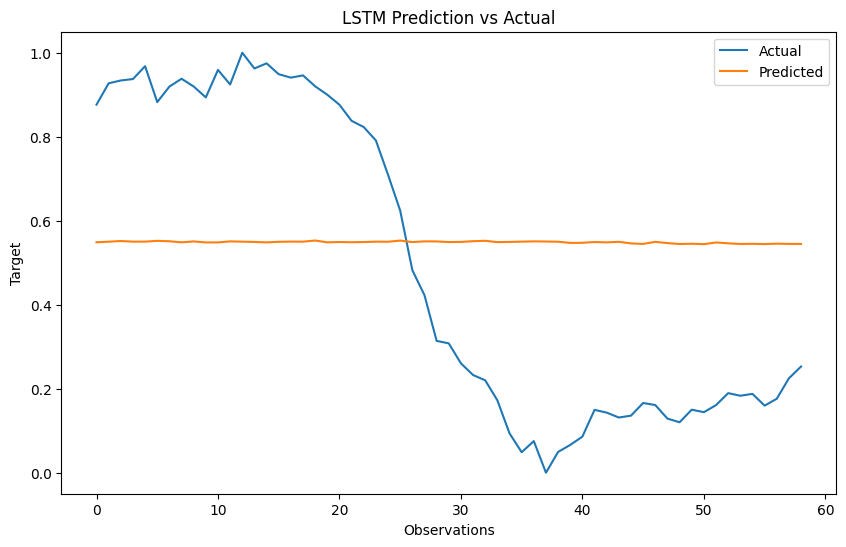

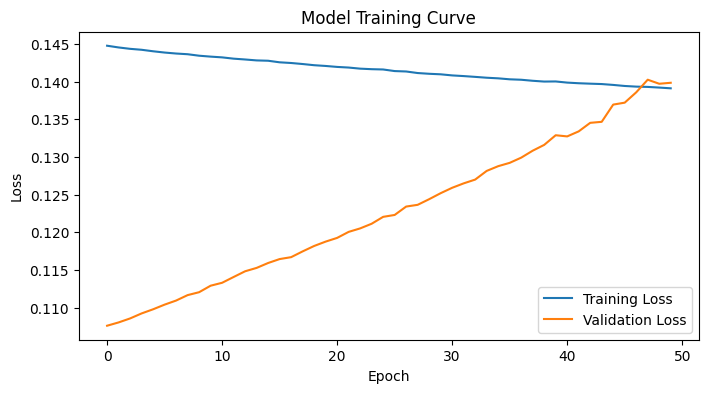

In [28]:
# 合并特征
X_combined = np.concatenate((train_features_scaled, test_features_scaled), axis=0)
# 合并标签
y_combined = np.concatenate((train_labels_scaled, test_labels_scaled), axis=0)
model_evaluation(lstm_model, "LSTM", X_combined, y_combined)
plt_history(history)